In [33]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import HTML
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, RobustScaler, TargetEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
import optuna
import mlflow

HTML(
"""
<style>
    h1{
        font-size:20px;
        font-family:Helvetica;
        color:blue;
    }
  
    
</style>
"""
)


<h1>1 - IMPORTING TRAIN AND TEST DATA</h1>

In [34]:
df_train = pd.read_csv("./data/train.csv")
df_train.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,55,165,60,81.0,0.5,0.6,1,1,135,87,94,172,300,40,75,16.5,1,1.0,22,25,27,0,1
1,1,70,165,65,89.0,0.6,0.7,2,2,146,83,147,194,55,57,126,16.2,1,1.1,27,23,37,1,0
2,2,20,170,75,81.0,0.4,0.5,1,1,118,75,79,178,197,45,93,17.4,1,0.8,27,31,53,0,1
3,3,35,180,95,105.0,1.5,1.2,1,1,131,88,91,180,203,38,102,15.9,1,1.0,20,27,30,1,0
4,4,30,165,60,80.5,1.5,1.0,1,1,121,76,91,155,87,44,93,15.4,1,0.8,19,13,17,0,1


In [35]:
df_test = pd.read_csv("./data/test.csv")
df_test.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
0,159256,40,165,70,84.0,1.2,1.2,1,1,130,89,107,200,186,49,115,14.2,1,0.9,19,25,32,0
1,159257,80,160,60,93.0,1.0,1.0,2,2,144,72,93,172,158,35,104,13.0,1,1.1,20,12,24,0
2,159258,60,170,70,86.5,0.6,0.7,1,1,117,75,92,161,173,39,88,15.4,1,1.4,38,60,36,0
3,159259,40,160,50,67.0,0.3,0.4,1,1,116,62,91,213,47,75,128,14.5,1,0.6,25,18,10,1
4,159260,40,170,75,89.4,1.0,0.9,1,1,132,94,79,170,100,39,123,16.5,1,1.0,30,39,27,1


In [36]:
df_test.shape

(106171, 23)

<ul>
    <li>
        Some columns have names with spaces
    </li>
    <li>
        This may cause some troubles later on, let's remove them
    </li>
</ul>

In [37]:
df_train.columns = [ col if' ' not in col else '_'.join(col.split(' ')).lower() for col in df_train.columns ]
df_train.columns = [col.lower() if col not in ('HDL','LDL') else col for col in df_train.columns ]

df_test.columns = [ col if' ' not in col else '_'.join(col.split(' ')).lower() for col in df_test.columns ]
df_test.columns = [col.lower() if col not in ('HDL','LDL') else col for col in df_test.columns ]


In [38]:
target = 'smoking'

<h1>Let's check whether there is missing data or duplicated data in the dataset</h1>

In [39]:
df_train.isna().sum()

id                     0
age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting_blood_sugar    0
cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
urine_protein          0
serum_creatinine       0
ast                    0
alt                    0
gtp                    0
dental_caries          0
smoking                0
dtype: int64

In [40]:
df_train.duplicated().sum()

0

In [41]:
df_test.isna().sum()

id                     0
age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting_blood_sugar    0
cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
urine_protein          0
serum_creatinine       0
ast                    0
alt                    0
gtp                    0
dental_caries          0
dtype: int64

In [42]:
df_test.duplicated().sum()

0

In [43]:
# df_train['height(cm)'] = df_train['height(cm)'].clip(lower=155,upper=180)
# df_train['weight(kg)'] = df_train['weight(kg)'].clip(lower=45,upper=100)
# df_train['age'] = df_train['age'].clip(upper=80)
# df_train['eyesight(right)'] = df_train['eyesight(right)'].clip(upper=1.5)
# df_train['eyesight(left)'] = df_train['eyesight(left)'].clip(upper=1.5)

<h1>There is no missing or duplicated data in both train and test sets</h1>
<hr>

<h1>2 - EDA and Feature Engineering</h1>

In [44]:
# Function to group variables and plot the target

def plot_barplot(x_var,prop_title=None):
    plt.figure(figsize=(10,5))

    g1 = plt.subplot(121)
    sns.barplot(data=df_train,x=x_var,y=target,ax=g1)
    plt.xticks(ha='right')
    g1.set_yticks(ticks=g1.get_yticks(),labels=[f'{val:.1%} 'for val in g1.get_yticks()])
    if prop_title is not None and isinstance(prop_title,str):
        g1.set_title(prop_title)

    g2 = plt.subplot(122)
    sns.countplot(data=df_train,x=x_var,hue=target,ax=g2)
    plt.xticks(ha='right')

    plt.tight_layout()

In [45]:
def plot_train_test_distribution(cat_features,num_features):
    n_features = len(cat_features) + len(num_features)
    features = num_features + cat_features 
    df_train_plot = df_train[features].copy()
    df_train_plot['label'] = 'TRAIN'
    
    df_test_plot = df_test[features].copy()
    df_test_plot['label'] = 'TEST'
    
    df_plot = pd.concat([df_train_plot,df_test_plot],axis=0)
    
    plt.tight_layout(w_pad=3,h_pad=4)
    for idx,f in enumerate(features):
        if f in num_features:
            fig = plt.figure(figsize=(15,4))
            plt.subplot(121)
            sns.histplot(data=df_plot,x=f,hue='label',kde=True)
            
            plt.subplot(122)
            sns.boxplot(data=df_plot,x=f,orient='h',y='label')
            
        if f in cat_features:
            plt.figure(figsize=(15,4))
            sns.countplot(data=df_plot,x=f,hue='label')
        plt.show()

In [46]:
def plot_target_variables_interaction(cat_features, num_features):
    n_features = len(cat_features) + len(num_features)
    features = num_features + cat_features 
    df_train_plot = df_train[features].copy()
    df_plot = df_train
    
    plt.tight_layout(w_pad=3,h_pad=4)
    for idx,f in enumerate(features):
        if f in num_features:
            fig = plt.figure(figsize=(15,4))
            plt.subplot(121)
            sns.histplot(data=df_plot,x=f,hue=target,kde=True)
            
            plt.subplot(122)
            sns.boxplot(data=df_plot,y=f,x=target)
            
        if f in cat_features:
            plt.figure(figsize=(15,4))
            sns.countplot(data=df_plot,x=f,hue=target)
        plt.show()
    plt.close()


<h2>2.1 - Target Distribution</h2>
<ul>
    <li>
        The target has a little imbalance.
    </li>
</ul>
<hr>

In [47]:
df_train[target].value_counts(normalize=True)

smoking
0    0.562635
1    0.437365
Name: proportion, dtype: float64

<Axes: xlabel='smoking', ylabel='count'>

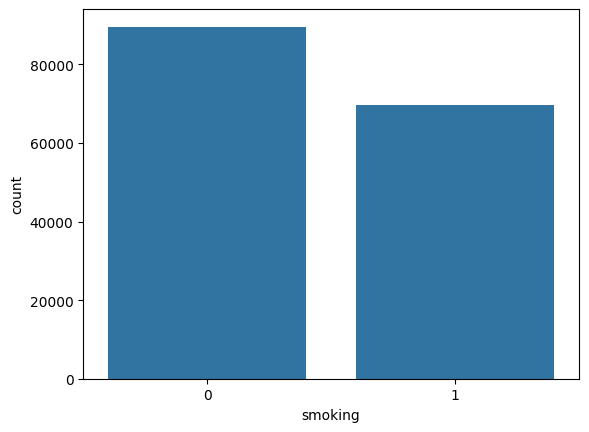

In [48]:
sns.countplot(data=df_train,x=target)

<h2>2.2 - Correlation Matrix</h2>
<ul>
    <li>
        <code>height</code> and <code>hemoglobin</code> are the most correlated features with the target.
    </li>
    <li>
        <code>LDL</code> has high correlation with <code>cholesterol</code>. It's interesting that <code>HDL</code> has low correlation with <code>cholesterol</code>. A combination of <code>LDL</code>, <code>HDL</code> and <code>cholesterol</code> may become an interesting feature, it will be explored during feature engineering.
    </li>
    <li>
        There are also some features with moderate correlation with one another. PCA may be worth a try as well.
    </li>
</ul>
<hr>

<Axes: >

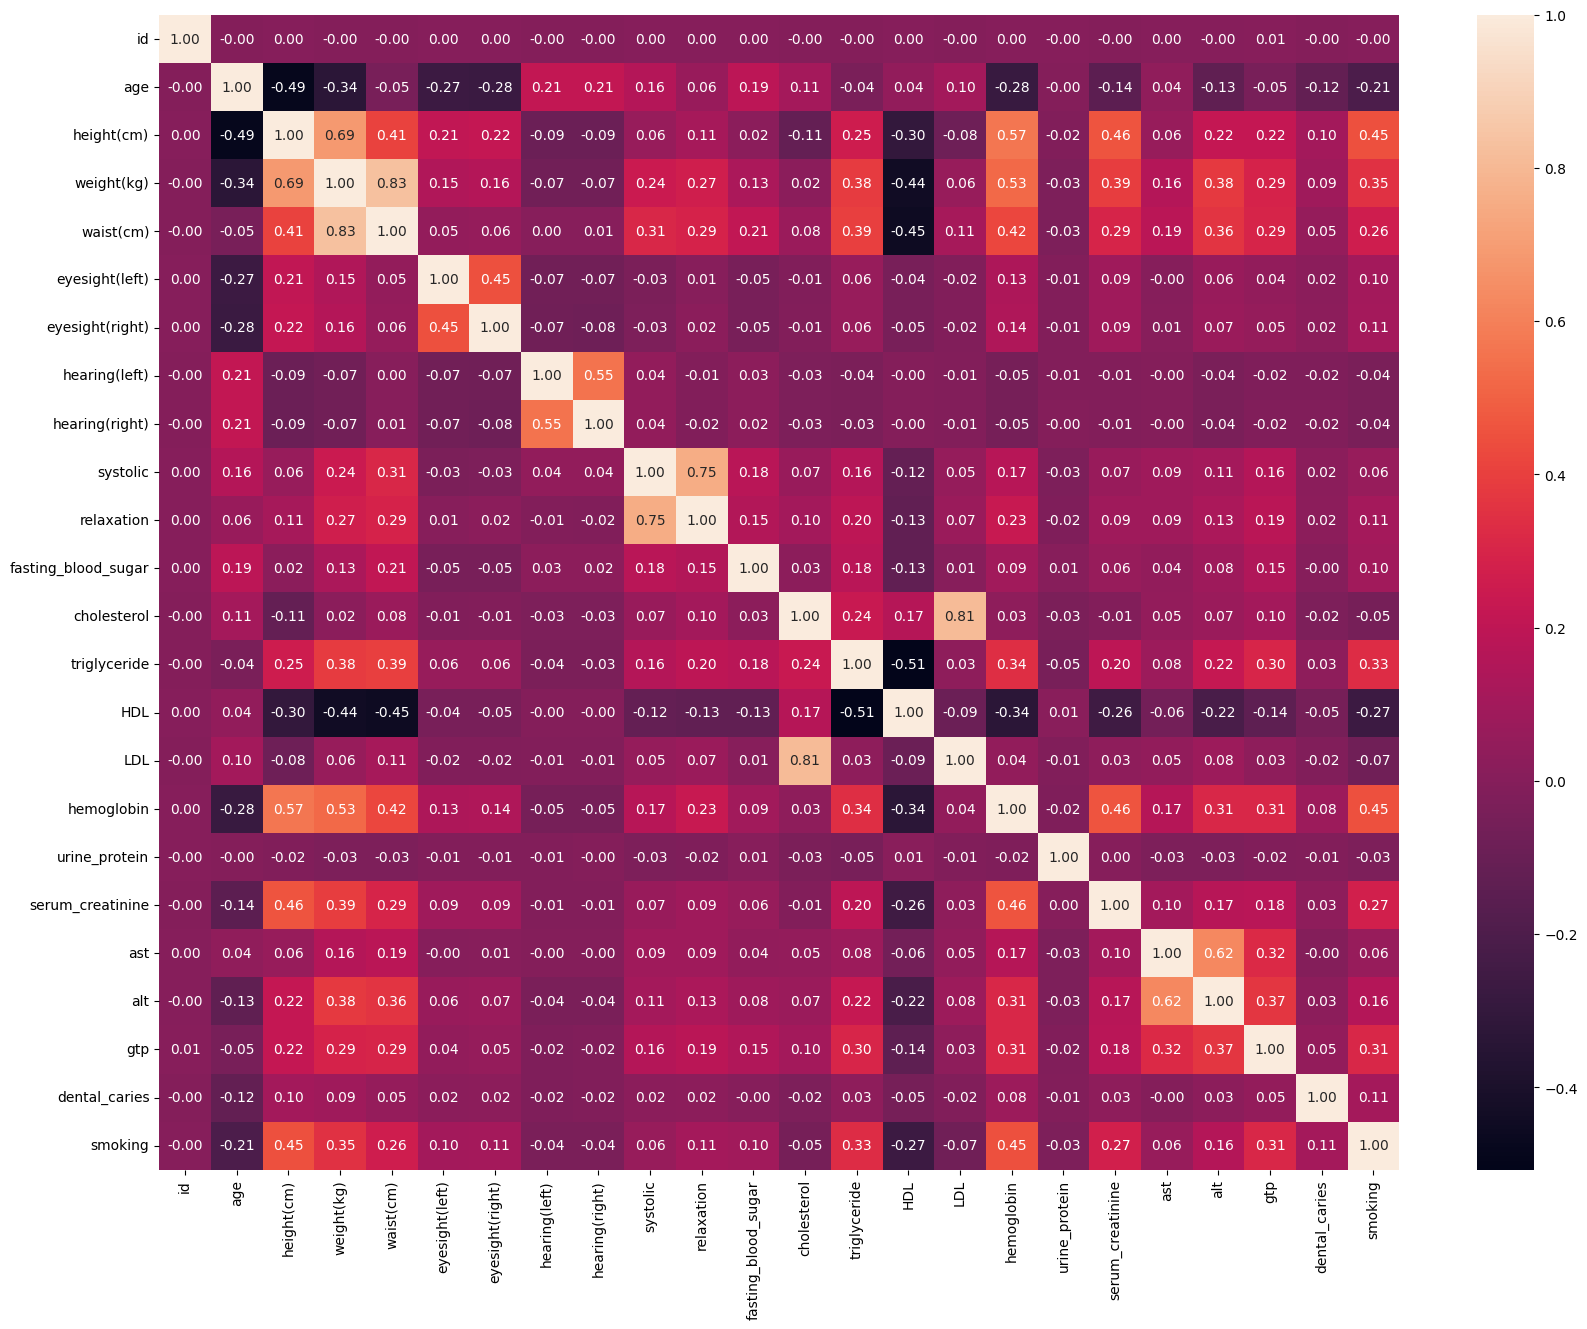

In [49]:
corr_map = df_train.corr()
plt.figure(figsize=(20,15))
sns.heatmap(data=corr_map,annot=True,fmt='.2f')

<h2>2.3 - Checking uniqueness of the data</h2>
<ul>
    <li>
        Some features have a low number of possible values.
    </li>
    <li>
        <code>hearing(left)</code>, <code>hearing(right)</code> and <code>dental_caries</code> have only 2 values and are categoriacal features. Their values in the dataset are 1 and 2, perhaps it is useful to change them to 0 or 1.
    </li>
    <li>
        <code>urine_protein</code>, <code>height(cm)</code>, <code>eyesight(right)</code> and <code>eyesight(left)</code> have also a low number of unique values. Grouping them should reveal trends and more information about the target
    </li>
</ul>
<hr>

In [50]:
df_train.drop(columns=['id',target]).nunique().to_frame().rename(columns={0:'n_unique'})

,n_unique
age,18
height(cm),14
weight(kg),28
waist(cm),531
eyesight(left),20
eyesight(right),17
hearing(left),2
hearing(right),2
systolic,112
relaxation,75


In [51]:
cat_features = df_train.drop(columns=['id',target]).nunique().to_frame().rename(columns={0:'n_unique'}).query("n_unique<=2").index.tolist()
num_features = list(set(df_train.drop(columns=['id',target]).columns) - set(cat_features))

features = num_features + cat_features

In [52]:
if len(num_features) + len(cat_features) + 2 != df_train.shape[1]:
    raise ValueError("dimensions do not match")

In [53]:
def plot_barplot(x_var,prop_title=None):
    plt.figure(figsize=(10,5))

    g1 = plt.subplot(121)
    sns.barplot(data=df_train,x=x_var,y=target,ax=g1)
    plt.xticks(ha='right')
    g1.set_yticks(ticks=g1.get_yticks(),labels=[f'{val:.1%} 'for val in g1.get_yticks()])
    if prop_title is not None and isinstance(prop_title,str):
        g1.set_title(prop_title)

    g2 = plt.subplot(122)
    sns.countplot(data=df_train,x=x_var,hue=target,ax=g2)
    plt.xticks(ha='right')

    plt.tight_layout()

In [54]:
# plot_train_test_distribution(cat_features=cat_features, num_features=num_features)

In [55]:
# plot_target_variables_interaction(cat_features=cat_features, num_features=num_features)

<h2>2.4 - Feature <code>age</code></h2>
<ul>
    <li>
        We see that som ages have 100% or 0% smokers. These happens because these ages have few people (maximum of 2). These ages also do not fit the patter of increment of the <code>age</code> feature, which is 5. I will round these ages to their nearest value multiple of 5.
    </li>
    <li>
        Smoking tends do decrease with <code>age</code>.
    </li>
</ul>
<hr>

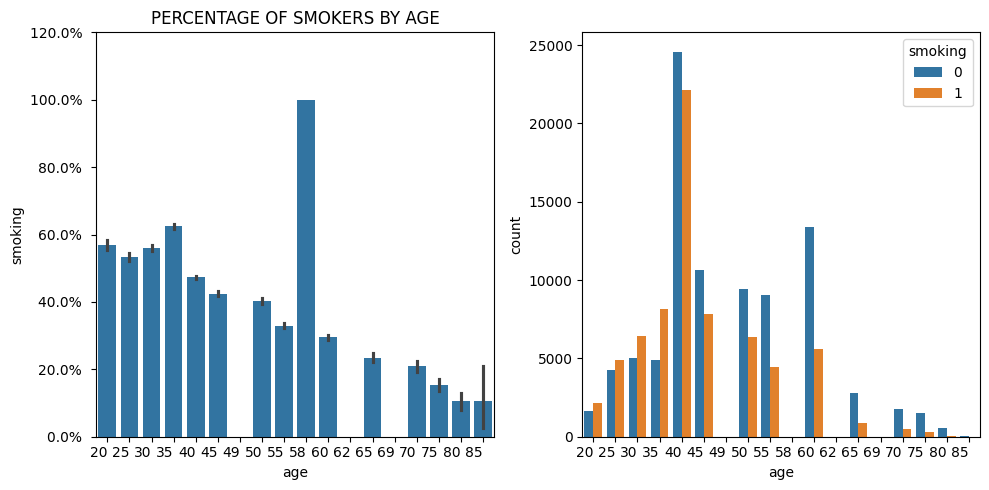

In [56]:
plot_barplot(x_var='age',prop_title="percentage of smokers by age".upper())

In [57]:
df_train[['age',target]].groupby(by='age').count().T

age,20,25,30,35,40,45,49,50,55,58,60,62,65,69,70,75,80,85
smoking,3829,9140,11465,13081,46691,18480,1,15768,13446,2,19043,1,3637,1,2229,1760,644,38


<h1>2.5 - Feature <code>height(cm)</code></h1>
<ul>
    <li>
        <code>height(cm)</code> has the same behavior of <code>age</code>: some values have only a few instances. They will be rounded to the nearest multiple of five as well
    </li>
</ul>
<hr>

In [58]:
df_train[['height(cm)',target]].groupby(by='height(cm)').count().T

height(cm),135,139,140,145,150,155,160,165,170,175,180,181,185,190
smoking,8,1,410,2736,11534,19597,22783,30145,37398,24852,8185,1,1562,44


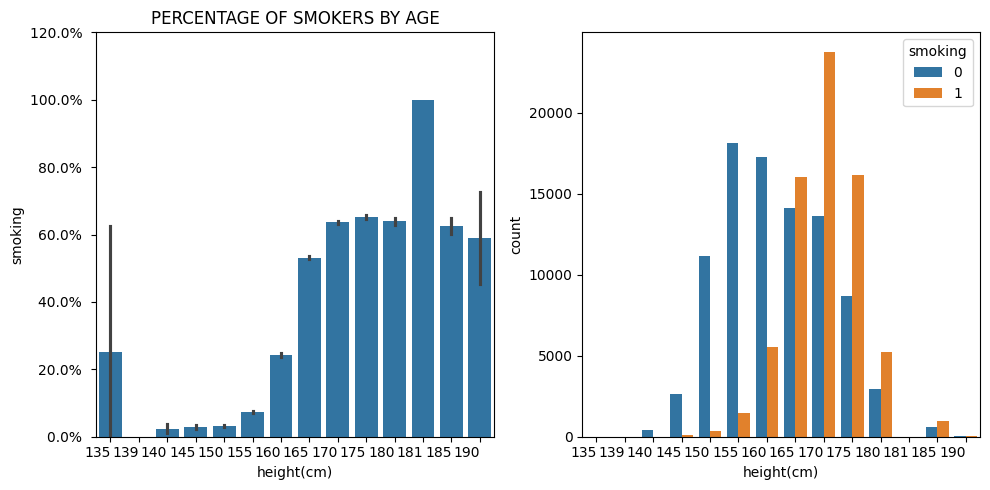

In [59]:
plot_barplot(x_var='height(cm)',prop_title="percentage of smokers by age".upper())

<h1>2.6 - Feature <code>weight(kg)</code></h1>
<ul>
    <li>
        <code>weight(kg)</code> has the same behavior of <code>age</code>: some values have only a few instances. The ones that are not a multiple of 5 will be rounded to the nearest multiple of 5 as well
    </li>
</ul>
<hr>

In [60]:
df_train[['weight(kg)',target]].groupby(by='weight(kg)').count().T

weight(kg),30,35,40,45,50,55,60,65,70,75,79,80,82,83,85,88,89,90,95,99,100,101,105,110,115,120,125,130
smoking,14,47,881,5420,13780,18715,21658,23069,24168,19698,1,13631,1,1,8612,1,1,4676,2647,1,1391,1,500,228,82,24,6,2


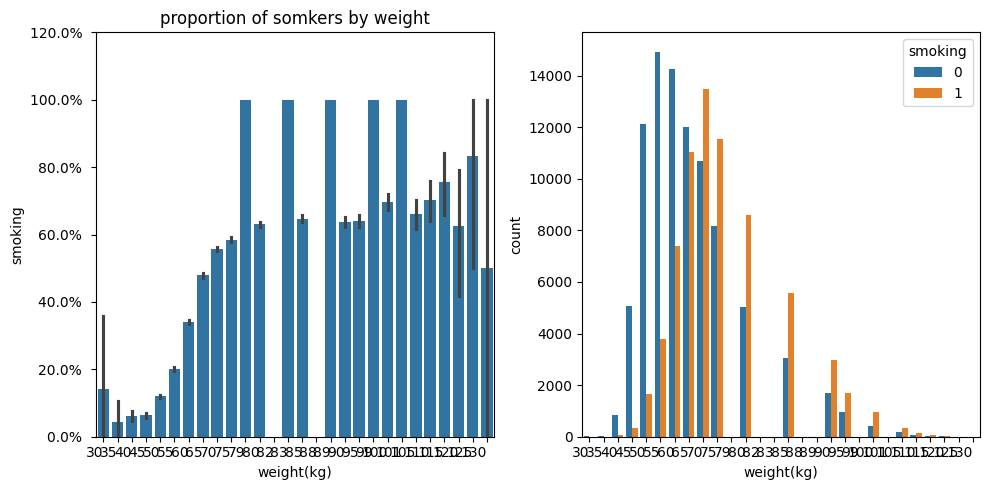

In [61]:
plot_barplot(x_var='weight(kg)',prop_title='proportion of somkers by weight')

<h1>2.7 - Feature <code>eyesight(left)	</code></h1>
<ul>
    <li>
        <code>eyesight(left)</code> has the same behavior of <code>age</code>: some values have only a few instances.
    </li>
</ul>
<hr>

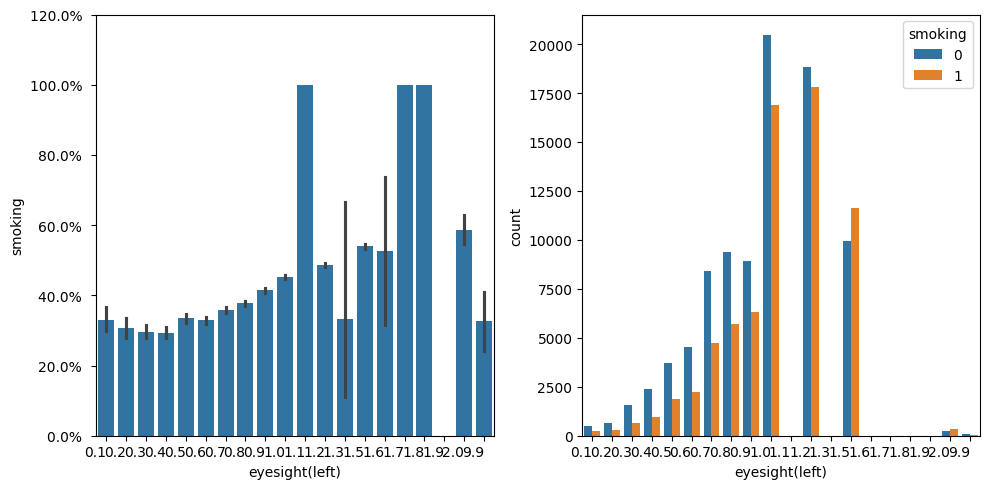

In [62]:
plot_barplot(x_var='eyesight(left)')

In [63]:
df_train[['eyesight(left)',target]].groupby(by='eyesight(left)').count().T

eyesight(left),0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.5,1.6,1.7,1.8,1.9,2.0,9.9
smoking,710,922,2235,3337,5599,6769,13124,15078,15212,37380,1,36618,9,21550,19,1,2,1,557,132


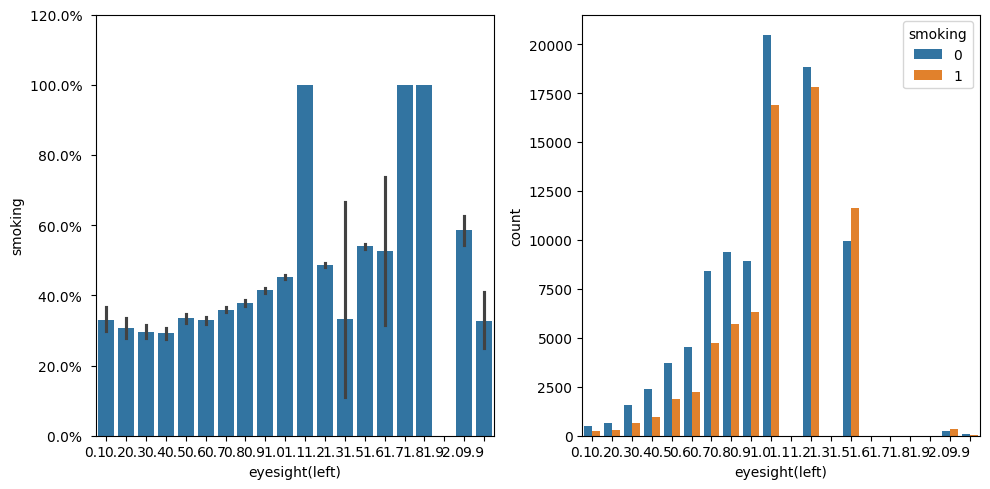

In [64]:
plot_barplot(x_var='eyesight(left)')

<h1>2.8 - Feature <code>eyesight(right)</code></h1>
<ul>
    <li>
        <code>eyesight(right)</code> has the same behavior of <code>age</code>: some values have only a few instances.
    </li>
</ul>
<hr>

In [65]:
df_train[['eyesight(right)',target]].groupby(by='eyesight(right)').count().T

eyesight(right),0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.2,1.3,1.4,1.5,1.6,2.0,9.9
smoking,803,1037,2116,3580,5838,6708,12144,15505,15719,38014,36302,3,2,20813,19,536,117


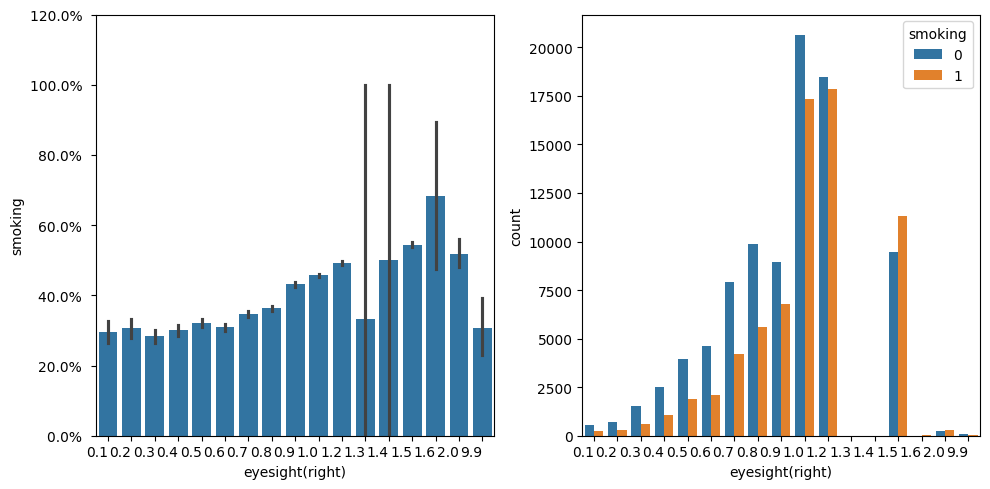

In [66]:
plot_barplot(x_var='eyesight(right)')

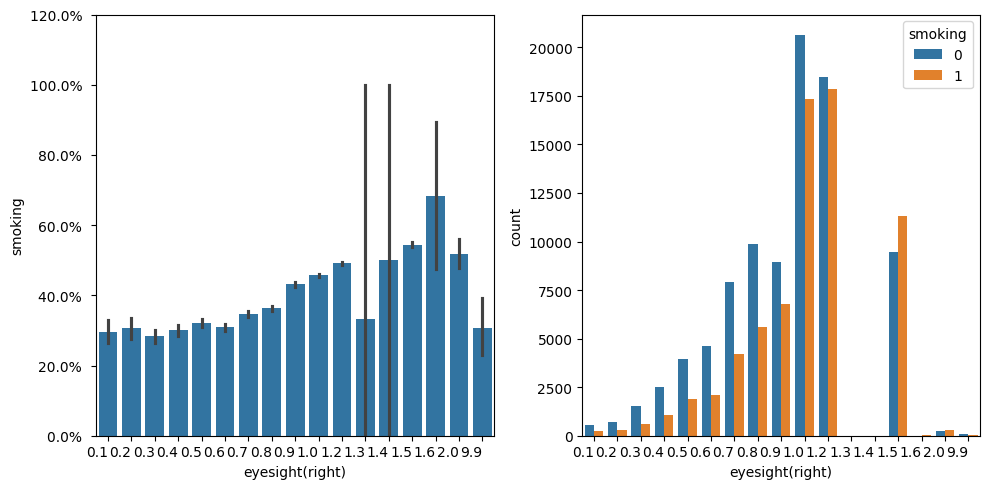

In [67]:
plot_barplot(x_var='eyesight(right)')

<h1>2.9 - Feature <code>urine_protein</code></h1>
<ul>
    <li>
        The vast majority of people have <code>urine_protein</code> = 1. Maybe turn this feature into a categorical one (<code>urine_protein</code> = 1 or <code>urine_protein</code> > 1) may be useful
    </li>
</ul>
<hr>

In [68]:
df_train[['urine_protein',target]].groupby(by='urine_protein').count().T

urine_protein,1,2,3,4,5,6
smoking,150862,5609,2228,477,74,6


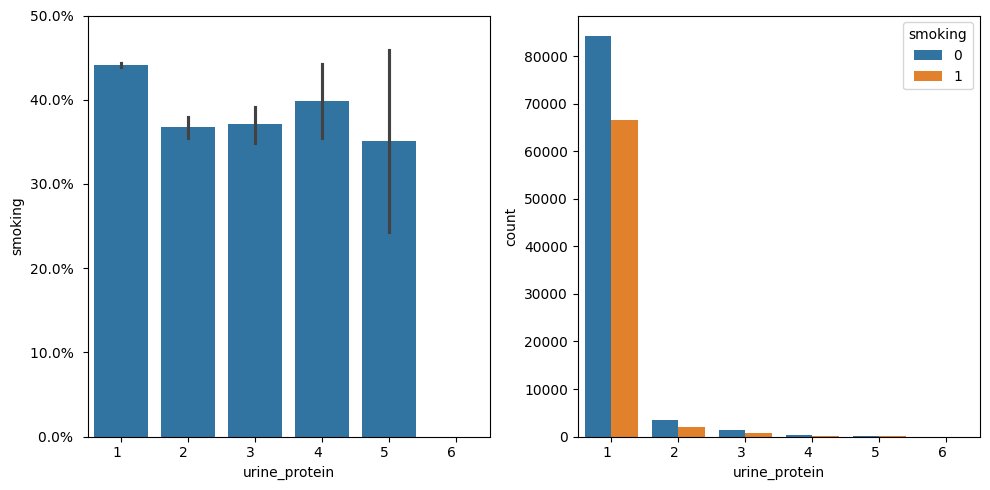

In [69]:
plot_barplot(x_var='urine_protein')

<h1>2.10 - Feature <code>HDL</code></h1>
<ul>
    <li>The distribution for HDL looks fine</li>
</ul>
<hr>

<Axes: xlabel='HDL', ylabel='Count'>

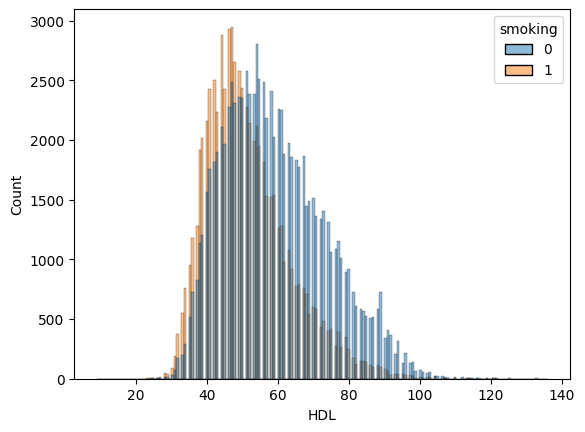

In [70]:
sns.histplot(data=df_train,x='HDL',hue=target)

<h1>2.11 - Feature <code>LDL</code></h1>
<ul>
    <li>The distribution for LDL seems to have some outliers</li>
    <li>Clipping the extreme values should be fine</li>
</ul>
<hr>

<Axes: xlabel='LDL', ylabel='Count'>

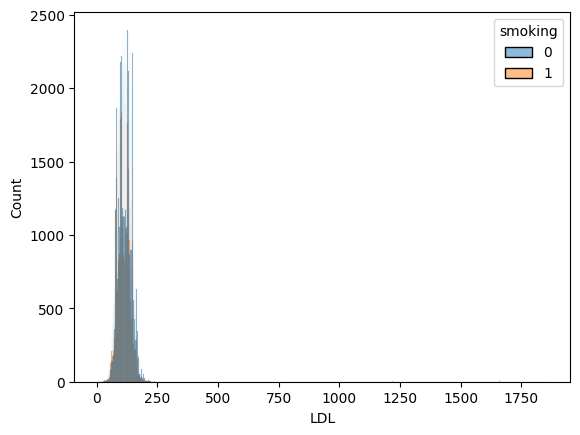

In [71]:
sns.histplot(data=df_train,x='LDL',hue=target)

<Axes: xlabel='LDL'>

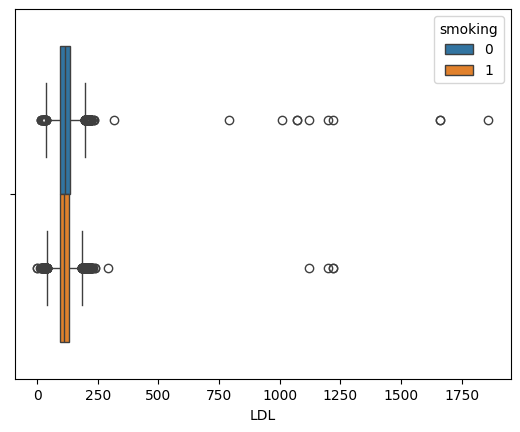

In [72]:
sns.boxplot(data=df_train,x='LDL',hue=target)

<h1>Data cleaning and feature engineering to be implemented:</h1>
<ul>
    <li>
        Round <code>age</code>, <code>height(cm)</code>, <code>weight(kg)</code>, <code>eyseight(left)</code> and <code>eyseight(right)</code>
    </li>
    <li>
        Create a categorical feature for <code>urine_protein</code>
    </li>
    <li>
        Boolean combinations of the features <code>hearing(left)</code> and <code>hearing(right)</code>. A person may have hearing problems in left AND right, left OR right or NEITHER left NOR right
    </li>
    <li>
        A feature engineering pipeline will be created.
    </li>
</ul>
<hr>

In [73]:
def round_to_nearest_multiple(df):
    
    df_to_edit = df.copy()
    def aux_round_to_nearest_multiple(val,multiple):
        rest = val % multiple
        if rest in (1, 2, 6 ,7):
            val_rounded = multiple * (val // multiple)
            return val_rounded
        elif rest in (3, 4, 8, 9):
            val_rounded = multiple * (val // multiple) + multiple
            return val_rounded
        else:
            return val
        
    df_to_edit['age'] = df_to_edit['age'].apply(aux_round_to_nearest_multiple, args=(5,))
    df_to_edit['height(cm)'] = df_to_edit['height(cm)'].apply(aux_round_to_nearest_multiple, args=(5,))
    df_to_edit['weight(kg)'] = df_to_edit['weight(kg)'].apply(aux_round_to_nearest_multiple, args=(5,))
    return df_to_edit

In [74]:
def boolean_hearing(df):
    df_to_edit = df.copy()

    df_to_edit['hearing_lef_and_right'] = df_to_edit['hearing(left)'].map(lambda x: 1 if x== 2 else 0) * df_to_edit['hearing(right)'].map(lambda x: 1 if x== 2 else 0)
    df_to_edit['hearing_lef_or_right'] = df_to_edit['hearing(left)'].map(lambda x: True if x== 2 else False) + df_to_edit['hearing(right)'].map(lambda x: True if x== 2 else False)

    return df_to_edit

In [75]:
def cholesterol_features(df):
    df_to_edit = df.copy()
    df_to_edit['LDL_to_HDL'] = df_to_edit['LDL'] / df_to_edit['HDL']
    df_to_edit['LDL_to_cholesterol'] = df_to_edit['LDL'] / df_to_edit['cholesterol']
    df_to_edit['HDL_to_cholesterol'] = df_to_edit['HDL'] / df_to_edit['cholesterol']

    return df_to_edit

In [76]:
def cat_urine_protein(df):
    df_to_edit = df.copy()
    df_to_edit['urine_protein_cat'] = df['urine_protein'].map(lambda x: 1 if x == 1 else 0)
    return df_to_edit

In [77]:
# Creation the feature engineering pipeline

feature_engineering_transformer = ColumnTransformer([
    ('round', FunctionTransformer(round_to_nearest_multiple, validate=False, feature_names_out='one-to-one'), ['age', 'height(cm)', 'weight(kg)']),
    ('boolean', FunctionTransformer(boolean_hearing, validate=False, feature_names_out='one-to-one'), ['hearing(left)', 'hearing(right)']),
    ('cholesterol_feature', FunctionTransformer(cholesterol_features, validate=False, feature_names_out='one-to-one'), ['LDL', 'HDL', 'cholesterol']),
    ('urine_features', FunctionTransformer(cat_urine_protein, validate=False, feature_names_out='one-to-one'), ['urine_protein']),
    ("not_features",'drop',['id',target]),
    
], remainder='passthrough', verbose_feature_names_out=True)

<h1>3 - Model</h1>
<hr>

<h2>First we need a baseline model. The performance of this model will serve as reference for future experiments</h2>
<ul>
    <li>
        As our validation strategy, we will use k-fold cross-validation
    </li>
    <li>
        Since the data has a small unbalance, sklearn KFold object should be enough, but a comparison with StratifedKfold will also be evaluated though.
    </li>
    <li>
        A XGBoost classifier will be used as a baseline
    </li>
</ul>
<hr>

In [78]:
def generate_submission(clf,title):
    df_to_pred = df_test.copy()
    X = df_to_pred.drop(columns=['id'])
    # X = df_to_pred[features]
    preds = clf.predict_proba(X)[:,1]
    df_to_pred[target] = preds
    df_to_pred[['id',target]].to_csv(f'./{title}.csv',index=False)


In [79]:
# defining the number of splits, the seed for random state and the k-fold cross-validation strategies
n_splits = 10
SEED = 100
cv = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)
st_cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)

In [80]:
# defining X and y
# X = df_train[features]
X = df_train.drop(columns=['id',target])
y = df_train[target]

<h2>Comments about the baseline model</h2>
<ul>
    <li>
        Our base ROC AUC score is 0.8659.
    </li>
    <li>
        The standard deviation between folds seems to be low, which is a good sign.
    </li>
    <li>
        The standard deviation for StratifiedKfold CV was lower, indicating that this validation can generalize better than the KFold CV (less overfitting).
    </li>
    <li>
        Every action performed from now on must be compared to this baseline result using the same validation strategy.
    </li>
</ul>
<hr>

In [81]:
from xgboost import XGBClassifier
baseline_model = XGBClassifier(random_state=SEED,objective= "binary:logistic",eval_metric='auc')
baseline_results_cv = cross_val_score(estimator=baseline_model, X=X, y=y, cv=cv, scoring='roc_auc')
baseline_results_stratified_cv = cross_val_score(estimator=baseline_model, X=X, y=y, cv=st_cv, scoring='roc_auc')

print("Baseline model using Kfold CV: \n",baseline_results_cv)
print(f"Mean score Kfold CV: {np.mean(baseline_results_cv):.5f} and Standard Deviation score Kfold CV: {np.std(baseline_results_cv):.5f}")
print("\n")
print("Baseline model using StratifiedKfold CV: \n",baseline_results_stratified_cv)
print(f"Mean score StratifiedKfold CV: {np.mean(baseline_results_stratified_cv):.5f} and Standard Deviation score StratifiedKfold CV: {np.std(baseline_results_stratified_cv):.5f}")


Baseline model using Kfold CV: 
 [0.86825164 0.86686416 0.87004353 0.86661548 0.8628408  0.86267504
 0.86585842 0.86448257 0.86743022 0.86401069]
Mean score Kfold CV: 0.86591 and Standard Deviation score Kfold CV: 0.00228


Baseline model using StratifiedKfold CV: 
 [0.86639893 0.86433025 0.865187   0.86726732 0.86595969 0.86403101
 0.86449567 0.86573567 0.86612703 0.86527115]
Mean score StratifiedKfold CV: 0.86548 and Standard Deviation score StratifiedKfold CV: 0.00096


In [82]:
def generate_feature_importance_df(model,X,y):
    model.fit(X,y)
    feature_importance = model.feature_importances_
    features_ = X.columns.tolist()
    dict_feature_importance = {'feature':features_,'importance':feature_importance}
    feature_importance_df = pd.DataFrame.from_dict(dict_feature_importance).sort_values(by='importance',ascending=False)
    return feature_importance_df

<Axes: xlabel='importance', ylabel='feature'>

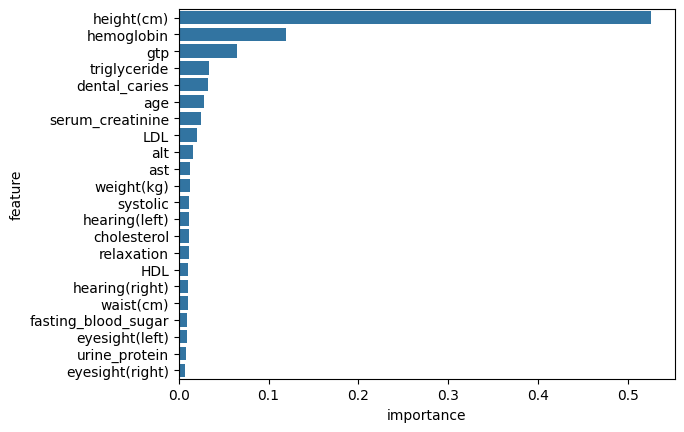

In [83]:
baseline_model_feature_importance_df = generate_feature_importance_df(model=baseline_model,X=X,y=y)
sns.barplot(data=baseline_model_feature_importance_df,x='importance',y='feature')


<ul>
    <li>
        The feature <code>height</code> has a big feature importance. It's possible that there is a confounding variable causing this behavior. For example, taller people tend to be heavier. A shorter person with high weight may have a high body fat percentage and a different behaviour relation to smoking.
    </li>
    <li>
        Intending to represent this characteristics, a new feature called <code>density</code> will be created as <code>weight(kg)</code> / ( &#960; * <code>waist(cm)</code>&#178; * <code>height(cm)</code>)
    </li>
</ul>
<hr>

In [84]:
baseline_model.fit(X,y)
# df_test['density'] = df_test['weight(kg)'] / np.pi * df_test['waist(cm)']**2 / df_test['height(cm)']
# generate_submission(baseline_model,'submission_density_clipping')


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=100, ...)

In [85]:
df_train['density'] = df_train['weight(kg)'] / np.pi * df_train['waist(cm)']**2 / df_train['height(cm)']

<ul>
    <li>
        The feature <code>density</code> seems to have no problems with outliers.
    </li>
    <li>
        People with higher <code>density</code> has a higher chance of smoking.
    </li>
    <li>
        The feature <code>density</code> improved the ROC AUC in the stratifed Kfold and had a good feature importance
    </li>
</ul>
<hr>

<Axes: xlabel='density', ylabel='Count'>

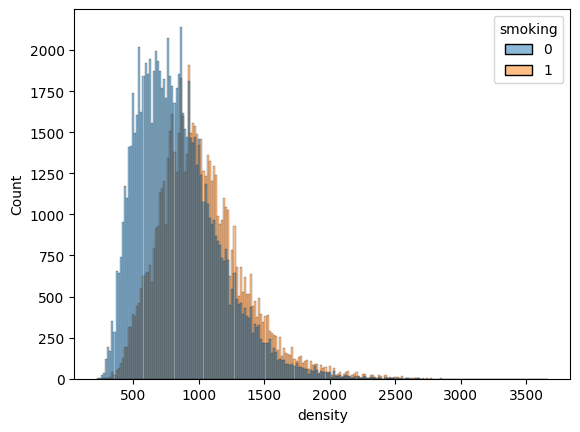

In [86]:
sns.histplot(data=df_train,x='density',hue=target)

In [87]:
from xgboost import XGBClassifier
X = df_train.drop(columns=['id',target])
baseline_model = XGBClassifier(random_state=SEED,objective= "binary:logistic",eval_metric='auc')
baseline_results_cv = cross_val_score(estimator=baseline_model, X=X, y=y, cv=cv, scoring='roc_auc')
baseline_results_stratified_cv = cross_val_score(estimator=baseline_model, X=X, y=y, cv=st_cv, scoring='roc_auc')


print("Baseline model using Kfold CV: \n",baseline_results_cv)
print(f"Mean score Kfold CV: {np.mean(baseline_results_cv):.5f} and Standard Deviation score Kfold CV: {np.std(baseline_results_cv):.5f}")
print("\n")
print("Baseline model using StratifiedKfold CV: \n",baseline_results_stratified_cv)
print(f"Mean score StratifiedKfold CV: {np.mean(baseline_results_stratified_cv):.5f} and Standard Deviation score StratifiedKfold CV: {np.std(baseline_results_stratified_cv):.5f}")


Baseline model using Kfold CV: 
 [0.86727377 0.86552676 0.86956848 0.86598773 0.86263694 0.86298543
 0.86417099 0.86565127 0.86749684 0.86444399]
Mean score Kfold CV: 0.86557 and Standard Deviation score Kfold CV: 0.00203


Baseline model using StratifiedKfold CV: 
 [0.86617646 0.86658338 0.86638041 0.86759318 0.86673867 0.86386707
 0.86644372 0.86538724 0.86590558 0.86583766]
Mean score StratifiedKfold CV: 0.86609 and Standard Deviation score StratifiedKfold CV: 0.00093


<Axes: xlabel='importance', ylabel='feature'>

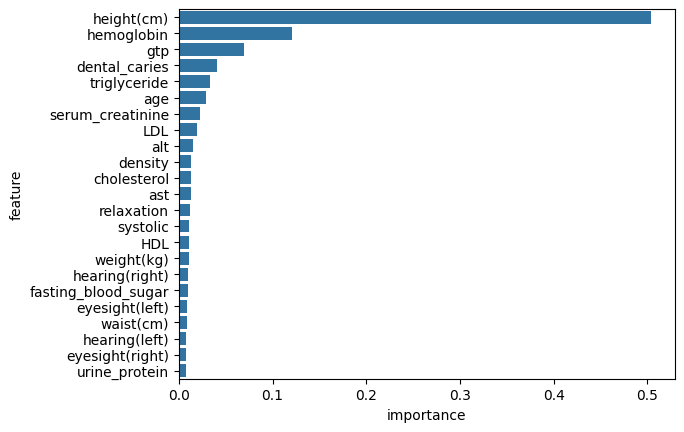

In [88]:
baseline_model_feature_importance_df = generate_feature_importance_df(model=baseline_model,X=X,y=y)
sns.barplot(data=baseline_model_feature_importance_df,x='importance',y='feature')


<h2>Clipping values and changing values with low number of instances</h2>
<ul>
    <li>Values with few instances for features <code>height(cm)</code>, <code>weight(kg)</code>, <code>age</code>, <code>eyesight(left)</code> and <code>eyesight(right)</code> will be rounded </li>
</ul>

In [89]:
df_train_treated = df_train.copy()
df_train_treated = round_to_nearest_multiple(df_train_treated)
df_train_treated['eyesight(left)'] = df_train_treated['eyesight(left)'].map(lambda v: 1.0 if v ==1.1 else 1.2 if v == 1.3 else v)
df_train_treated['eyesight(right)'] = df_train_treated['eyesight(right)'].map(lambda v: 1.2 if v in (1.3, 1.4) else v)

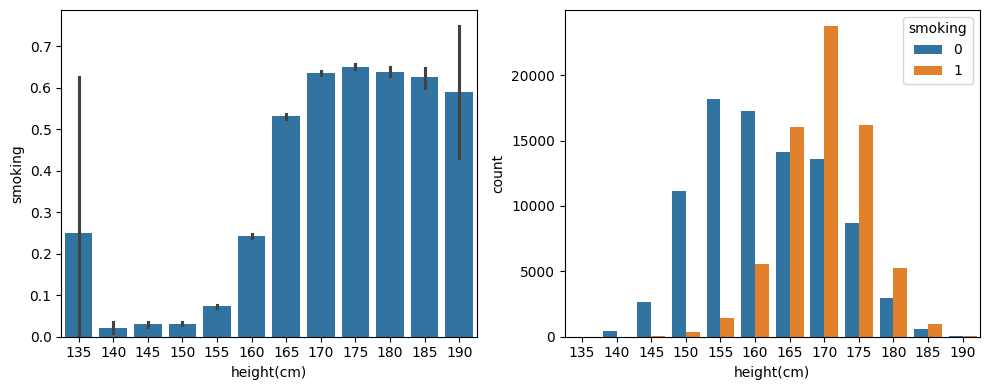

In [90]:
plt.figure(figsize=(10,4))
plt.subplot(121)
sns.barplot(data=df_train_treated,x='height(cm)',y=target)
plt.subplot(122)
sns.countplot(data=df_train_treated,x='height(cm)',hue=target)
plt.tight_layout()

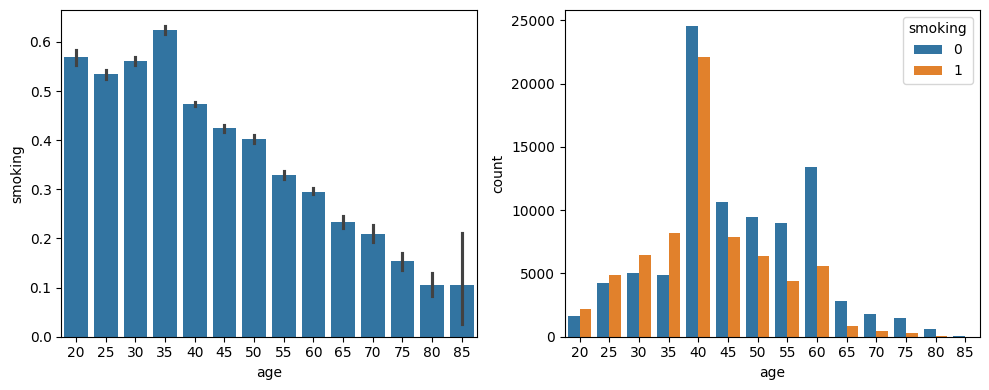

In [91]:
plt.figure(figsize=(10,4))
plt.subplot(121)
sns.barplot(data=df_train_treated,x='age',y=target)
plt.subplot(122)
sns.countplot(data=df_train_treated,x='age',hue=target)
plt.tight_layout()

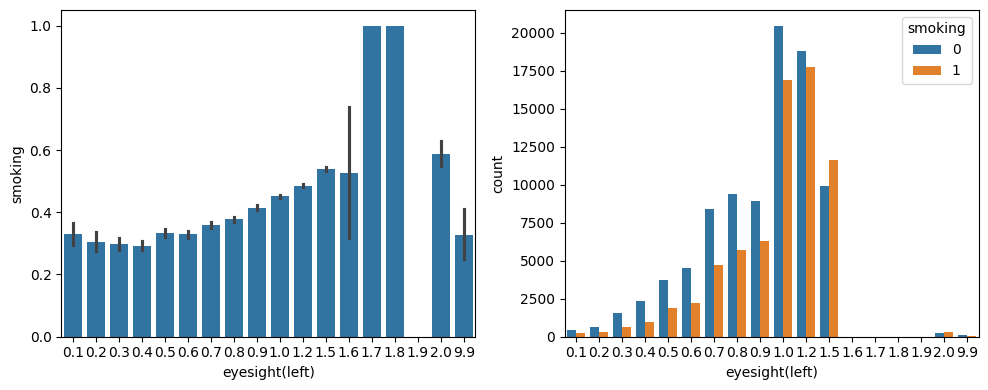

In [92]:
plt.figure(figsize=(10,4))
plt.subplot(121)
sns.barplot(data=df_train_treated,x='eyesight(left)',y=target)
plt.subplot(122)
sns.countplot(data=df_train_treated,x='eyesight(left)',hue=target)
plt.tight_layout()

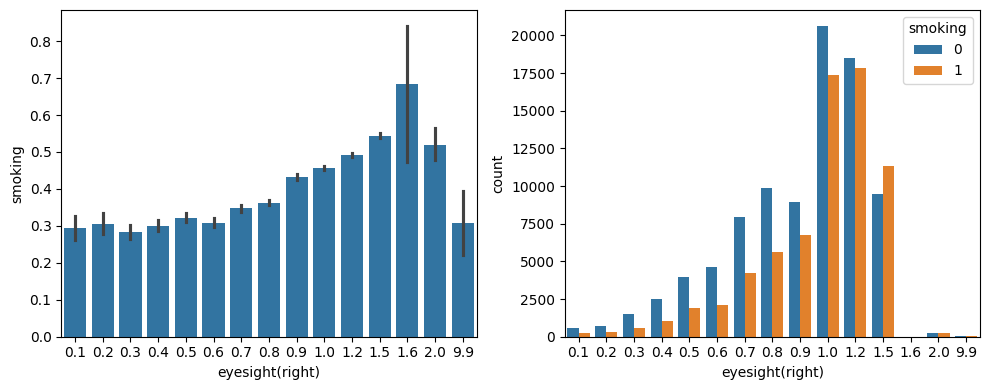

In [93]:
plt.figure(figsize=(10,4))
plt.subplot(121)
sns.barplot(data=df_train_treated,x='eyesight(right)',y=target)
plt.subplot(122)
sns.countplot(data=df_train_treated,x='eyesight(right)',hue=target)
plt.tight_layout()

<ul>
    <li>The values with few instances have high oscilations in the probabilites of smoking due to the low number of instances</li>
    <li>The variables will be clipped</li>
</ul>

In [94]:
df_train_treated['height(cm)'] = df_train_treated['height(cm)'].clip(lower=155,upper=180)
df_train_treated['weight(kg)'] = df_train_treated['weight(kg)'].clip(lower=45,upper=100)
df_train_treated['age'] = df_train_treated['age'].clip(upper=80)
df_train_treated['eyesight(right)'] = df_train_treated['eyesight(right)'].clip(upper=1.5)
df_train_treated['eyesight(left)'] = df_train_treated['eyesight(left)'].clip(upper=1.5)

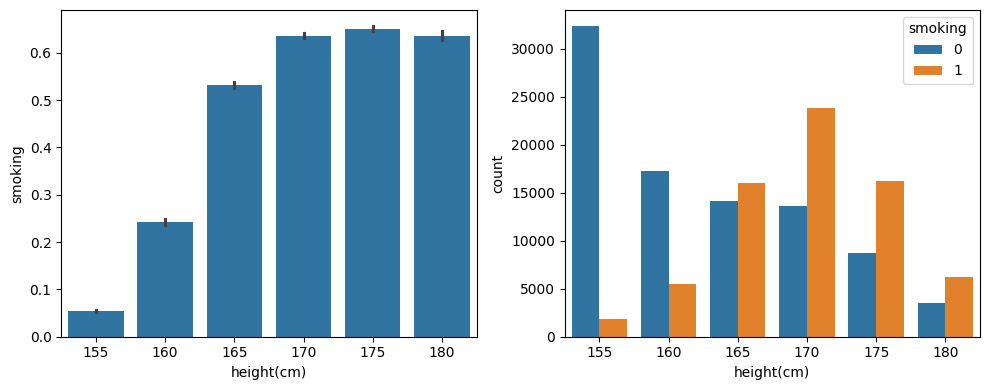

In [95]:
plt.figure(figsize=(10,4))
plt.subplot(121)
sns.barplot(data=df_train_treated,x='height(cm)',y=target)
plt.subplot(122)
sns.countplot(data=df_train_treated,x='height(cm)',hue=target)
plt.tight_layout()

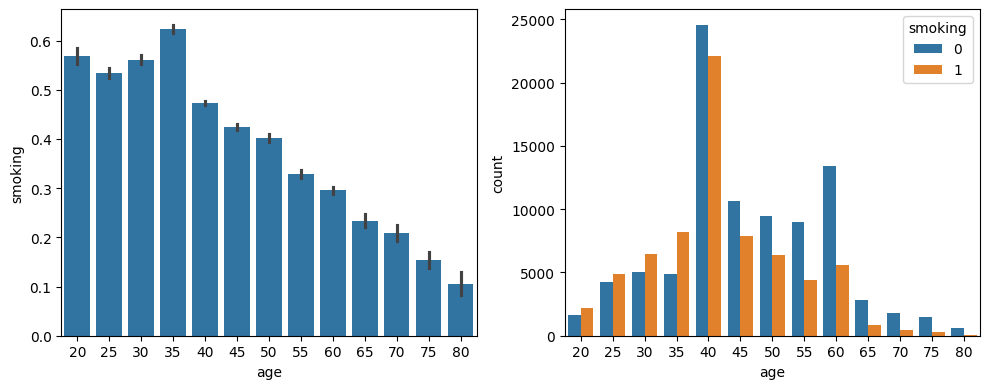

In [96]:
plt.figure(figsize=(10,4))
plt.subplot(121)
sns.barplot(data=df_train_treated,x='age',y=target)
plt.subplot(122)
sns.countplot(data=df_train_treated,x='age',hue=target)
plt.tight_layout()

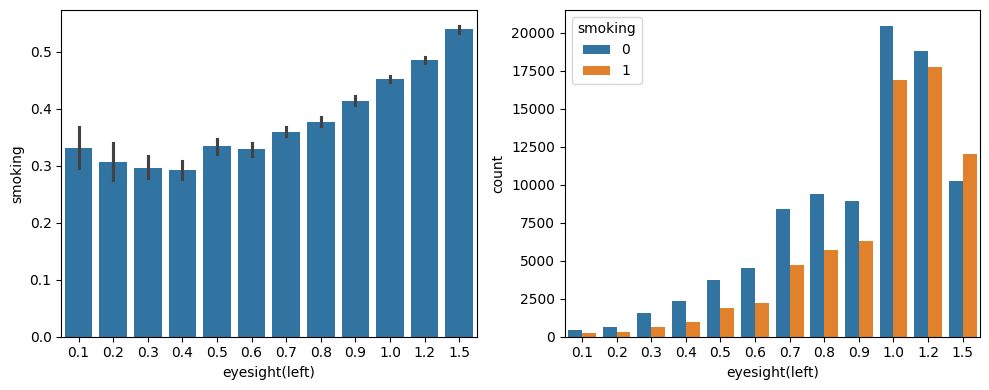

In [97]:
plt.figure(figsize=(10,4))
plt.subplot(121)
sns.barplot(data=df_train_treated,x='eyesight(left)',y=target)
plt.subplot(122)
sns.countplot(data=df_train_treated,x='eyesight(left)',hue=target)
plt.tight_layout()

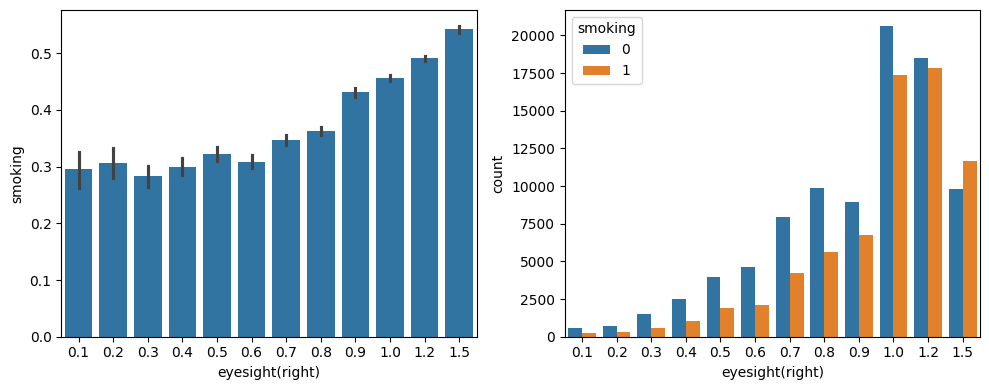

In [98]:
plt.figure(figsize=(10,4))
plt.subplot(121)
sns.barplot(data=df_train_treated,x='eyesight(right)',y=target)
plt.subplot(122)
sns.countplot(data=df_train_treated,x='eyesight(right)',hue=target)
plt.tight_layout()

<ul>The outliers of the feature <code>LDL</code> must be dealt with</ul>

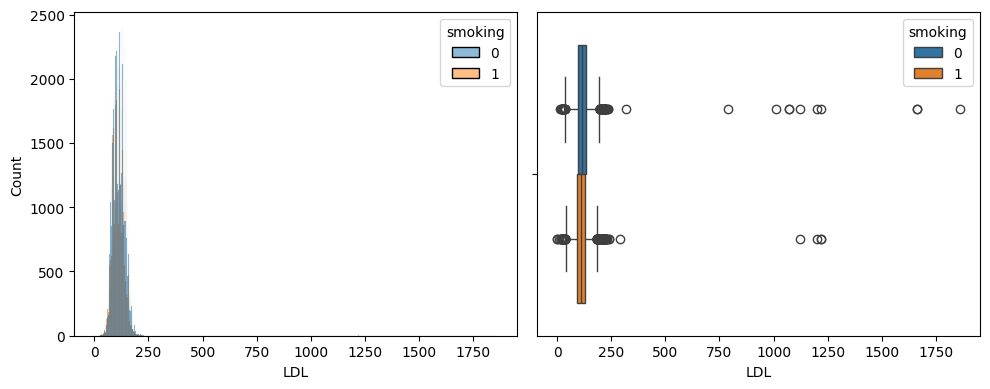

In [99]:
plt.figure(figsize=(10,4))
plt.subplot(121)
sns.histplot(data=df_train_treated,x='LDL',hue=target)
plt.subplot(122)
sns.boxplot(data=df_train_treated,x='LDL',hue=target)
plt.tight_layout()

In [100]:
df_train_treated['LDL'] = df_train_treated['LDL'].clip(upper=df_train_treated.query("LDL<250")['LDL'].max())

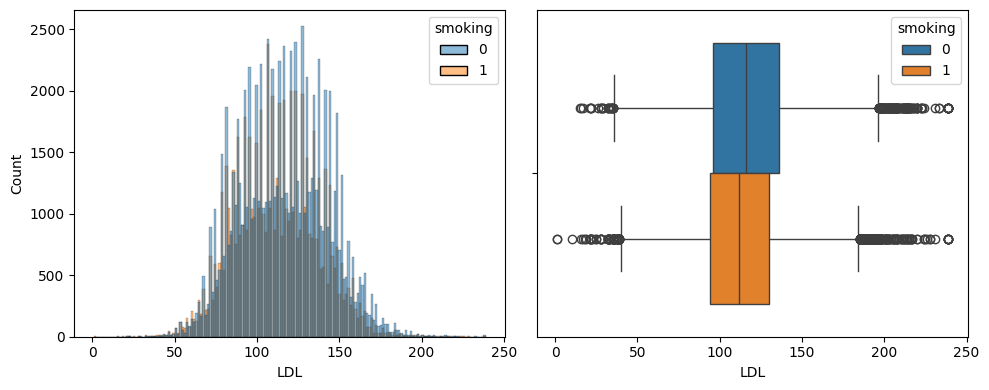

In [101]:
plt.figure(figsize=(10,4))
plt.subplot(121)
sns.histplot(data=df_train_treated,x='LDL',hue=target)
plt.subplot(122)
sns.boxplot(data=df_train_treated,x='LDL',hue=target)
plt.tight_layout()

In [102]:
df_train_treated['density'] = df_train_treated['weight(kg)'] / np.pi * df_train_treated['waist(cm)']**2 / df_train_treated['height(cm)']

<Axes: xlabel='density', ylabel='Count'>

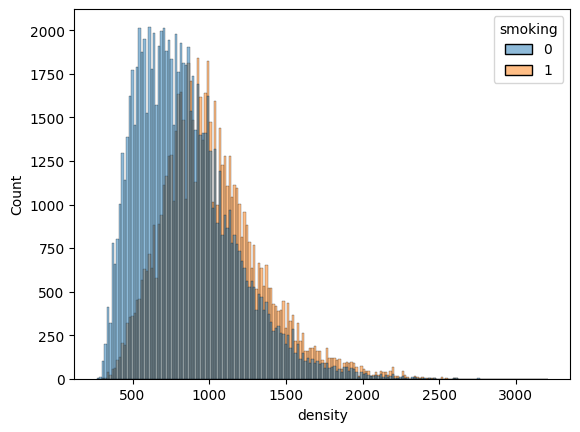

In [103]:
sns.histplot(data=df_train_treated,x='density',hue=target)


<ul>
    <li>The dsitributions look smoother now</li>
</ul>

<h2>Removing Outliers</h2>

In [104]:
# from sklearn.ensemble import IsolationForest
# from sklearn.neighbors import LocalOutlierFactor

# iso_f = LocalOutlierFactor(n_neighbors=80,n_jobs=-1)
# preds = iso_f.fit_predict(df_train[features])
# df_train['outlier'] = preds
# df_train = df_train.query("outlier==1")
# df_train.drop(columns='outlier',inplace=True)
# df_train['density'] = df_train['weight(kg)'] / np.pi * df_train['waist(cm)']**2 / df_train['height(cm)']


In [105]:
# parameters =  {'booster': 'gbtree', 'lambda': 0.017277394350615587, 'alpha': 0.2701610154935442, 'subsample': 0.8478788568070617, 'colsample_bytree': 0.47571387733384396, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.0259905262775039, 'gamma': 0.0224428023930127, 'grow_policy': 'depthwise', 'n_estimators': 1700}

parameters = {'booster': 'gbtree', 'lambda': 0.006006466393520952, 'alpha': 0.2149403153937637, 'subsample': 0.8885656438805557, 'colsample_bytree': 0.37835343984693914, 'max_depth': 5, 'min_child_weight': 28, 'eta': 0.06489137776357176, 'gamma': 0.33505345772323325, 'grow_policy': 'lossguide', 'n_estimators': 1700}

# from xgboost import XGBClassifier
# baseline_model = XGBClassifier(random_state=SEED,objective= "binary:logistic",eval_metric='auc',**parameters)
# baseline_results_cv = cross_val_score(estimator=baseline_model, X=X, y=y, cv=cv, scoring='roc_auc')
# baseline_results_stratified_cv = cross_val_score(estimator=baseline_model, X=X, y=y, cv=st_cv, scoring='roc_auc')

# print("Baseline model using Kfold CV: \n",baseline_results_cv)
# print(f"Mean score Kfold CV: {np.mean(baseline_results_cv):.5f} and Standard Deviation score Kfold CV: {np.std(baseline_results_cv):.5f}")
# print("\n")
# print("Baseline model using StratifiedKfold CV: \n",baseline_results_stratified_cv)
# print(f"Mean score StratifiedKfold CV: {np.mean(baseline_results_stratified_cv):.5f} and Standard Deviation score StratifiedKfold CV: {np.std(baseline_results_stratified_cv):.5f}")



In [106]:
pipeline = [
    round_to_nearest_multiple,
    # boolean_hearing,
    # cholesterol_features,
    # cat_urine_protein
]

df_fe = df_train.copy()
for step in pipeline:
    df_fe = step(df_fe)

hleft = 'hearing(left)'
hright = 'hearing(right)'
eright = 'eyesight(right)'
eleft = 'eyesight(left)'
X_fe = df_fe.drop(columns=['id',target,'urine_protein'])
y_fe = df_fe[target]

<Axes: xlabel='weight(kg)', ylabel='smoking'>

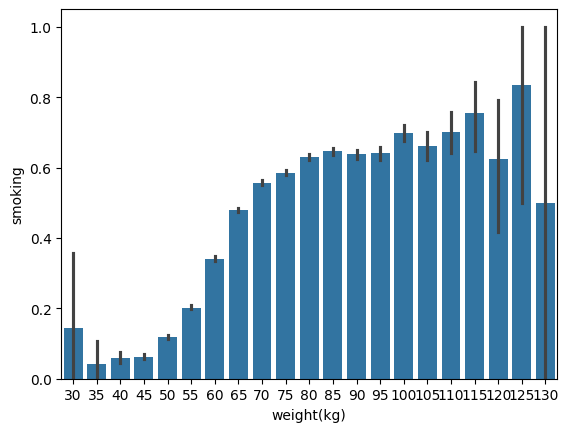

In [107]:
sns.barplot(data=df_fe,x='weight(kg)',y=target)

<Axes: xlabel='density', ylabel='Count'>

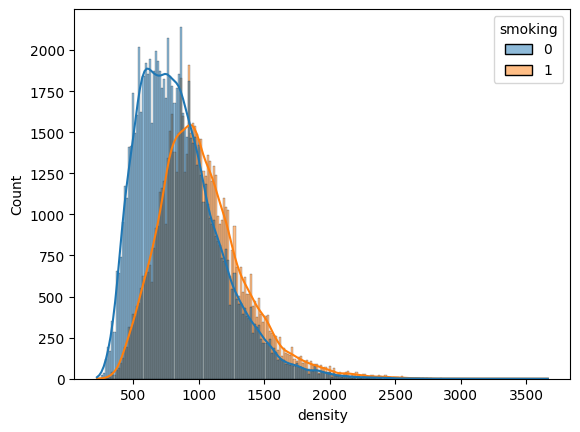

In [108]:
sns.histplot(data=df_fe,x='density',hue=target,kde=True)

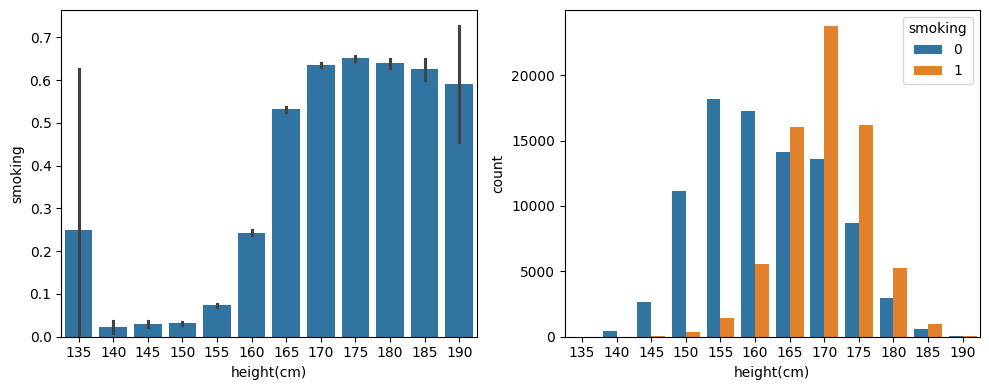

In [109]:
plt.figure(figsize=(10,4))
plt.subplot(121)
sns.barplot(data=df_fe,x='height(cm)',y=target)
plt.subplot(122)
sns.countplot(data=df_fe,x='height(cm)',hue=target)
plt.tight_layout()

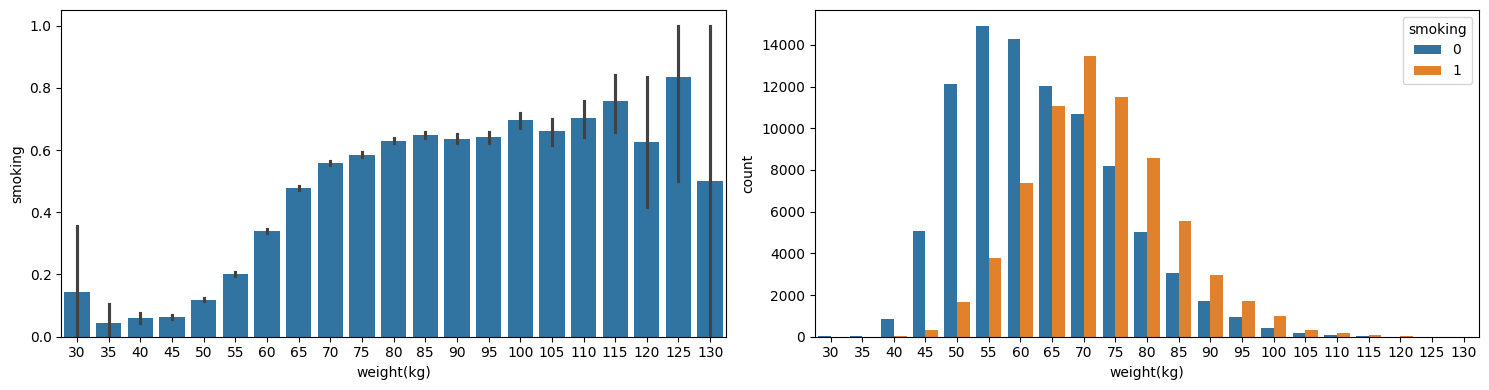

In [110]:
plt.figure(figsize=(15,4))
plt.subplot(121)
sns.barplot(data=df_fe,x='weight(kg)',y=target)
plt.subplot(122)
sns.countplot(data=df_fe,x='weight(kg)',hue=target)
plt.tight_layout()

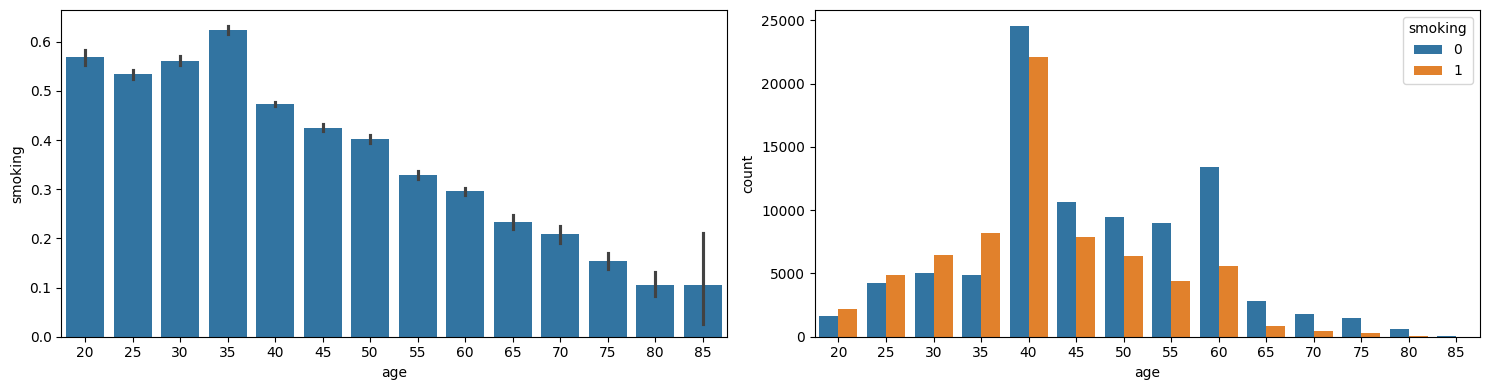

In [111]:
plt.figure(figsize=(15,4))
plt.subplot(121)
sns.barplot(data=df_fe,x='age',y=target)
plt.subplot(122)
sns.countplot(data=df_fe,x='age',hue=target)
plt.tight_layout()

In [112]:
from xgboost import XGBClassifier
baseline_model = XGBClassifier(random_state=SEED,objective= "binary:logistic",eval_metric='auc')
baseline_results_cv = cross_val_score(estimator=baseline_model, X=X_fe, y=y_fe, cv=cv, scoring='roc_auc')
baseline_results_stratified_cv = cross_val_score(estimator=baseline_model, X=X_fe, y=y_fe, cv=st_cv, scoring='roc_auc')

print("Baseline model using Kfold CV: \n",baseline_results_cv)
print(f"Mean score Kfold CV: {np.mean(baseline_results_cv):.4f} and Standard Deviation score Kfold CV: {np.std(baseline_results_cv):.4f}")
print("\n")
print("Baseline model using StratifiedKfold CV: \n",baseline_results_stratified_cv)
print(f"Mean score StratifiedKfold CV: {np.mean(baseline_results_stratified_cv):.4f} and Standard Deviation score StratifiedKfold CV: {np.std(baseline_results_stratified_cv):.4f}")


Baseline model using Kfold CV: 
 [0.86681854 0.86597121 0.86893464 0.86612331 0.86326608 0.86321001
 0.86448529 0.86397107 0.86710023 0.86348283]
Mean score Kfold CV: 0.8653 and Standard Deviation score Kfold CV: 0.0018


Baseline model using StratifiedKfold CV: 
 [0.86552333 0.86461048 0.86624653 0.86732802 0.86771542 0.86307643
 0.86361164 0.86549626 0.86503037 0.8649391 ]
Mean score StratifiedKfold CV: 0.8654 and Standard Deviation score StratifiedKfold CV: 0.0014


<Axes: xlabel='importance', ylabel='feature'>

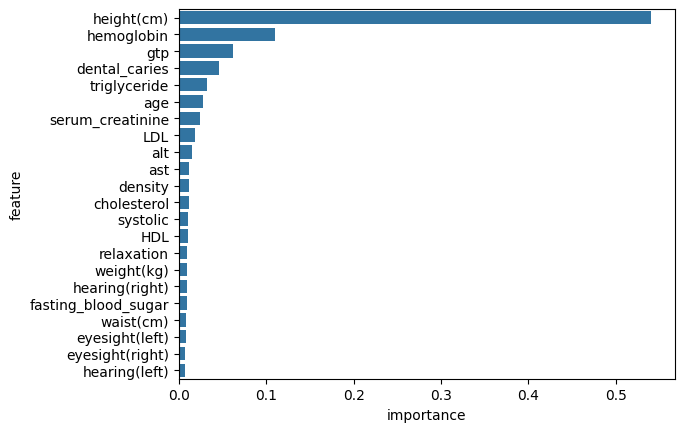

In [113]:
baseline_model_feature_importance_df = generate_feature_importance_df(model=baseline_model,X=X_fe,y=y_fe)
sns.barplot(data=baseline_model_feature_importance_df,x='importance',y='feature')


<h2>Evaluating the feature engineering process</h2>
<ul>
    <li>
        Now let's try to apply the feature engineering early proposed and check if it improves the results.
    </li>
</ul>
<hr>

In [114]:
xgb_fe_pipeline = Pipeline(
    [
        ('transformer',feature_engineering_transformer),
        ('classifier',XGBClassifier(random_state = SEED,objective= "binary:logistic",eval_metric='auc'))
    ]
)

In [115]:
fe_model = xgb_fe_pipeline
fe_cv = cross_val_score(estimator=fe_model, X=df_train, y=y, cv=cv, scoring='roc_auc')
fe_stratified_cv = cross_val_score(estimator=fe_model, X=df_train, y=y, cv=st_cv, scoring='roc_auc')

print("Baseline model using Kfold CV:")
print(f"--- Mean score Kfold CV: {np.mean(fe_cv):.4f} and Standard Deviation score Kfold CV: {np.std(fe_cv):.4f}")
print(fe_cv)
print("\n")
print("Baseline model using StratifiedKfold CV:")
print(f"--- Mean score StratifiedKfold CV: {np.mean(fe_stratified_cv):.4f} and Standard Deviation score StratifiedKfold CV: {np.std(baseline_results_stratified_cv):.4f}")
print(fe_stratified_cv)


Baseline model using Kfold CV:
--- Mean score Kfold CV: 0.8651 and Standard Deviation score Kfold CV: 0.0019
[0.86707839 0.86525161 0.86884569 0.86466632 0.86370556 0.86228698
 0.86402166 0.86519981 0.86671217 0.86290513]


Baseline model using StratifiedKfold CV:
--- Mean score StratifiedKfold CV: 0.8652 and Standard Deviation score StratifiedKfold CV: 0.0014
[0.86534883 0.86441023 0.86588571 0.86799293 0.86519108 0.86261987
 0.8644902  0.8649043  0.86561289 0.86540574]


In [116]:
xgb_fe_pipeline.fit(df_train,y)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('round',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function round_to_nearest_multiple at 0x000001B76D0CDDA0>),
                                                  ['age', 'height(cm)',
                                                   'weight(kg)']),
                                                 ('boolean',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function boolean_hearing at 0x000001B76D0...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=100, ...))])

In [117]:
def tune_xgboost(ntrials):
    clf = XGBClassifier(random_state = SEED,objective= "binary:logistic",eval_metric='auc')
    # clf = xgb_fe_pipeline
    param_distributions = {
        "n_estimators": optuna.distributions.IntDistribution(20, 500,step=10),
        "max_depth": optuna.distributions.IntDistribution(2, 9,step=1),
        "eta":optuna.distributions.FloatDistribution(1e-8,1,log=True),
        "min_child_weight":optuna.distributions.IntDistribution(2,10),
        "gamma":optuna.distributions.FloatDistribution(1e-8,1.0,log=True),
        # "scale_pos_weight":optuna.distributions.FloatDistribution(2,5.0),
        "colsample_bytree": optuna.distributions.FloatDistribution(0.2, 1.0),
        "subsample": optuna.distributions.FloatDistribution( 0.2, 1.0),
        "lambda": optuna.distributions.FloatDistribution( 1e-8, 1.0, log=True),
        "alpha": optuna.distributions.FloatDistribution( 1e-8, 1.0, log=True),
        'grow_policy':optuna.distributions.CategoricalDistribution(choices=['depthwise', 'lossguide'])
        
    }
    optuna_search = optuna.integration.OptunaSearchCV(clf, param_distributions,random_state=SEED,n_jobs=-1,cv=st_cv,scoring='roc_auc',n_trials=ntrials)
    optuna_search.fit(df_train, y)

    return optuna_search

In [118]:
# xgb_optuna_clg = tune_xgboost(20)

In [119]:
# generate_submission(xgb_optuna_clg.best_estimator_,'xgb_optuna_submission')

In [124]:
mlflc = optuna.integration.MLflowCallback()
@mlflc.track_in_mlflow()
def objective(trial):
    mlflow.xgboost.autolog()
    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        # "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-4, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-2, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "n_estimators": trial.suggest_int("n_estimators",1000,2000,step=50)
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 2, 8, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 30)
        param["eta"] = trial.suggest_float("eta", 1e-3, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-2, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    estimator = XGBClassifier(**param,random_state=SEED)
    results = cross_val_score(estimator=estimator, X=X, y=y, cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=SEED), scoring='roc_auc',n_jobs=-1)

    mlflow.log_metric('roc_auc',np.mean(results))
    mlflow.log_param('params',param)

#     estimator = Pipeline(
#     [
#         ('transformer',feature_engineering_transformer),
#         ('classifier',XGBClassifier(**param, random_state = SEED,eval_metric='auc'))
#     ]
# )
#     results = cross_val_score(estimator=estimator, X=df_train, y=y, cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=SEED), scoring='roc_auc',n_jobs=-1)
    
    return np.mean(results)


# if __name__ == "__main__":

#     study = optuna.create_study(direction="maximize")
#     study.optimize(objective, n_trials=50)

#     print("Number of finished trials: ", len(study.trials))
#     print("Best trial:")
#     trial = study.best_trial

#     print("  Value: {}".format(trial.value))
#     print("  Params: ")
#     for key, value in trial.params.items():
#         print("    {}: {}".format(key, value))

C:\Users\andre\AppData\Local\Temp\ipykernel_19112\2878358096.py:1: ExperimentalWarning: MLflowCallback is experimental (supported from v1.4.0). The interface can change in the future.
  mlflc = optuna.integration.MLflowCallback()
C:\Users\andre\AppData\Local\Temp\ipykernel_19112\2878358096.py:2: ExperimentalWarning: track_in_mlflow is experimental (supported from v2.9.0). The interface can change in the future.
  @mlflc.track_in_mlflow()
[I 2023-11-10 20:36:09,212] A new study created in memory with name: no-name-9ac936ae-8349-4358-aeb1-d73366d00dbe
2023/11/10 20:36:09 INFO mlflow.tracking.fluent: Experiment with name 'no-name-9ac936ae-8349-4358-aeb1-d73366d00dbe' does not exist. Creating a new experiment.
[I 2023-11-10 20:36:50,259] Trial 0 finished with value: 0.8551897170157368 and parameters: {'booster': 'gbtree', 'lambda': 0.0037288616728286613, 'alpha': 0.09212824881995428, 'subsample': 0.7227215913329779, 'colsample_bytree': 0.5013341570715419, 'n_estimators': 1800, 'max_depth':

Number of finished trials:  50
Best trial:
  Value: 0.8717971623339421
  Params: 
    booster: gbtree
    lambda: 0.003120935592686985
    alpha: 0.018236943496092662
    subsample: 0.9560521864842187
    colsample_bytree: 0.24017028364363285
    n_estimators: 1100
    max_depth: 8
    min_child_weight: 19
    eta: 0.029480119601456866
    gamma: 0.01282793706842193
    grow_policy: depthwise


# implementar o CV para o dmatrix

In [89]:
def objective(trial):
    import xgboost as xgb
    from sklearn.model_selection import train_test_split
    train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.25)
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        # "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        # "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "booster": trial.suggest_categorical("booster", ["gbtree"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 30)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    num_rounds = trial.suggest_int('boosting_rounds',100,2000,100)
    

    bst = xgb.train(param, dtrain,num_rounds)
    preds = bst.predict(dvalid)

    accuracy = roc_auc_score(y_true=valid_y,y_score=preds)
    return accuracy


# if __name__ == "__main__":
#     study = optuna.create_study(direction="maximize")
#     study.optimize(objective, n_trials=100, timeout=600)

#     print("Number of finished trials: ", len(study.trials))
#     print("Best trial:")
#     trial = study.best_trial

#     print("  Value: {}".format(trial.value))
#     print("  Params: ")
#     for key, value in trial.params.items():
#         print("    {}: {}".format(key, value))

In [90]:
# generate_submission(xgb_fe_pipeline, "fe_submission")

In [91]:
# from sklearn.feature_selection import SequentialFeatureSelector

# sfs = SequentialFeatureSelector(xgb_fe_pipeline, n_features_to_select=15,n_jobs=-1,cv=StratifiedKFold(n_splits=5),scoring='roc_auc',direction='backward')
# sfs.fit(df_train, y)
# sfs.get_support()
# # sfs.transform(X).shape

In [92]:
# sfs.get_params

In [93]:
# np.array(features)[sfs.get_support()]

In [94]:
import tensorflow as tf

In [95]:
from sklearn.model_selection import train_test_split
X = df_train.drop(columns=['id',target])
X = StandardScaler().fit_transform(X)
y = df_train[target]
xTrain, xTest, yTrain, yTest = train_test_split(X,y,random_state=SEED,stratify=y)

In [96]:
# dataset = te_tranformer.fit_transform(df_train,y)
# X = dataset
# y = df_train[target]
# xTrain, xTest, yTrain, yTest = train_test_split(X,y,random_state=22,stratify=y,test_size=0.2)

In [97]:
model = tf.keras.models.Sequential([
  # tf.keras.layers.Flatten(input_shape=(X.shape[1],)),
  tf.keras.layers.Input(shape=X.shape[1]),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(32, activation='relu'),
  # tf.keras.layers.Dropout(0.01),
  # tf.keras.layers.Dense(16, activation='relu'),
  # tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['AUC'])

In [98]:
model.fit(xTrain, yTrain, epochs=36,workers=4)

model.evaluate(xTest,  yTest, verbose=2)


Epoch 1/36
3733/3733 [==============================] - 5s 1ms/step - loss: 0.4870 - auc: 0.8325
Epoch 2/36
3733/3733 [==============================] - 4s 1ms/step - loss: 0.4687 - auc: 0.8465
Epoch 3/36
3733/3733 [==============================] - 4s 1ms/step - loss: 0.4652 - auc: 0.8494
Epoch 4/36
3733/3733 [==============================] - 4s 1ms/step - loss: 0.4619 - auc: 0.8519
Epoch 5/36
3733/3733 [==============================] - 4s 1ms/step - loss: 0.4615 - auc: 0.8521
Epoch 6/36
3733/3733 [==============================] - 4s 1ms/step - loss: 0.4606 - auc: 0.8527
Epoch 7/36
3733/3733 [==============================] - 4s 1ms/step - loss: 0.4598 - auc: 0.8534
Epoch 8/36
3733/3733 [==============================] - 4s 1ms/step - loss: 0.4588 - auc: 0.8538
Epoch 9/36
3733/3733 [==============================] - 4s 1ms/step - loss: 0.4585 - auc: 0.8545
Epoch 10/36
3733/3733 [==============================] - 4s 1ms/step - loss: 0.4573 - auc: 0.8554
Epoch 11/36
3733/3733 [======

[0.4598395824432373, 0.8585360050201416]

In [99]:
# preds_nn = model.predict(df_test.drop(columns=['id']))

In [100]:
# df_sub = df_test.copy()
# df_sub[target] = 1-preds_nn[:,0]


In [101]:
# df_sub[['id',target]].to_csv("submission_nn.csv",index=False)